# Import Libraries

In [14]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimb
from torchvision import datasets, transforms

## Data Transformations

The ToTensor transformation is essential for converting images into a format that PyTorch can work with(tensors).

The Normalize transformation is critical for standardizing the input data, which can lead to faster convergence during training. The mean and standard deviation values used should be calculated based on the dataset we are working with.


In [15]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [16]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders

The dataloader_args dictionary is used to configure the DataLoader. Using a larger batch size when CUDA is available can help utilize the GPU more efficiently.

The shuffle=True argument in dataloader_args ensures that the data is shuffled at the beginning of each epoch, which can help improve model generalization.

num_workers is set to 4 to enable parallel data loading, which can speed up the data loading process.

pin_memory=True allows for faster data transfer to the GPU by pinning memory on the host (CPU) side.

The DataLoader is responsible for loading the data in batches and applying any specified transformations. It provides an iterable over the dataset for easy integration with training and testing loops.

In [17]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


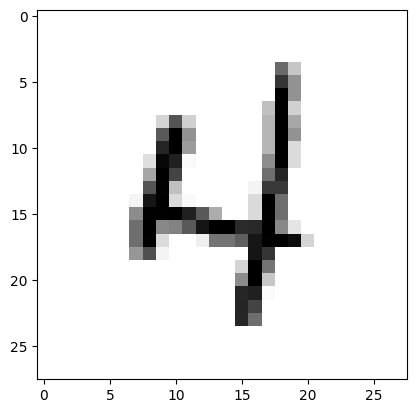

In [18]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)


print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

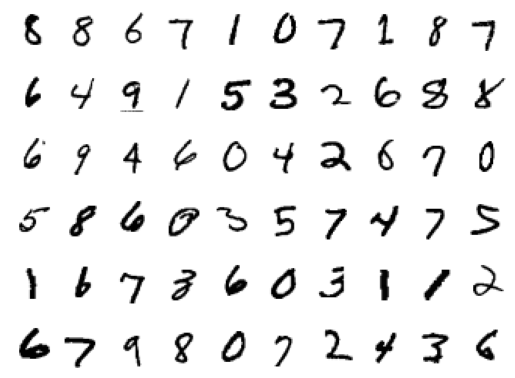

In [19]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
        MaxPool2d-10           [-1, 20, 11, 11]               0
           Conv2d-11           [-1, 10, 11, 11]             200
      BatchNorm2d-12           [-1, 10, 11, 11]              20
             ReLU-13           [-1, 10, 11, 11]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.08452156186103821 Batch_id=468 Accuracy=94.52: 100%|██████████| 469/469 [00:17<00:00, 26.56it/s]



Test set: Average loss: 0.0660, Accuracy: 9777/10000 (97.77%)

EPOCH: 1


Loss=0.04168889299035072 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:21<00:00, 21.98it/s]



Test set: Average loss: 0.0373, Accuracy: 9891/10000 (98.91%)

EPOCH: 2


Loss=0.06305244565010071 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:17<00:00, 27.05it/s]



Test set: Average loss: 0.0323, Accuracy: 9896/10000 (98.96%)

EPOCH: 3


Loss=0.01083706971257925 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:16<00:00, 29.12it/s]



Test set: Average loss: 0.0300, Accuracy: 9911/10000 (99.11%)

EPOCH: 4


Loss=0.008703246712684631 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:16<00:00, 28.10it/s]



Test set: Average loss: 0.0317, Accuracy: 9892/10000 (98.92%)

EPOCH: 5


Loss=0.021490052342414856 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:16<00:00, 29.07it/s]



Test set: Average loss: 0.0278, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.023629838600754738 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:18<00:00, 25.94it/s]



Test set: Average loss: 0.0243, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.035191815346479416 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:15<00:00, 29.86it/s]



Test set: Average loss: 0.0227, Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss=0.004777454771101475 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]



Test set: Average loss: 0.0280, Accuracy: 9910/10000 (99.10%)

EPOCH: 9


Loss=0.001183863147161901 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:16<00:00, 28.93it/s]



Test set: Average loss: 0.0235, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.030963191762566566 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:15<00:00, 29.55it/s]



Test set: Average loss: 0.0239, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.06416569650173187 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:17<00:00, 27.44it/s]



Test set: Average loss: 0.0224, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.005361682269722223 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]



Test set: Average loss: 0.0245, Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.03415059670805931 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]



Test set: Average loss: 0.0280, Accuracy: 9913/10000 (99.13%)

EPOCH: 14


Loss=0.0031535346060991287 Batch_id=468 Accuracy=99.76: 100%|██████████| 469/469 [00:16<00:00, 27.77it/s]



Test set: Average loss: 0.0248, Accuracy: 9916/10000 (99.16%)

EPOCH: 15


Loss=0.017749115824699402 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]



Test set: Average loss: 0.0252, Accuracy: 9925/10000 (99.25%)

EPOCH: 16


Loss=0.0013129980070516467 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:16<00:00, 28.47it/s]



Test set: Average loss: 0.0324, Accuracy: 9909/10000 (99.09%)

EPOCH: 17


Loss=0.0010396111756563187 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:15<00:00, 30.22it/s]



Test set: Average loss: 0.0240, Accuracy: 9926/10000 (99.26%)

EPOCH: 18


Loss=0.0006211153813637793 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]



Test set: Average loss: 0.0230, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Loss=0.002204260556027293 Batch_id=468 Accuracy=99.90: 100%|██████████| 469/469 [00:15<00:00, 29.42it/s]



Test set: Average loss: 0.0227, Accuracy: 9933/10000 (99.33%)



Text(0.5, 1.0, 'Test Accuracy')

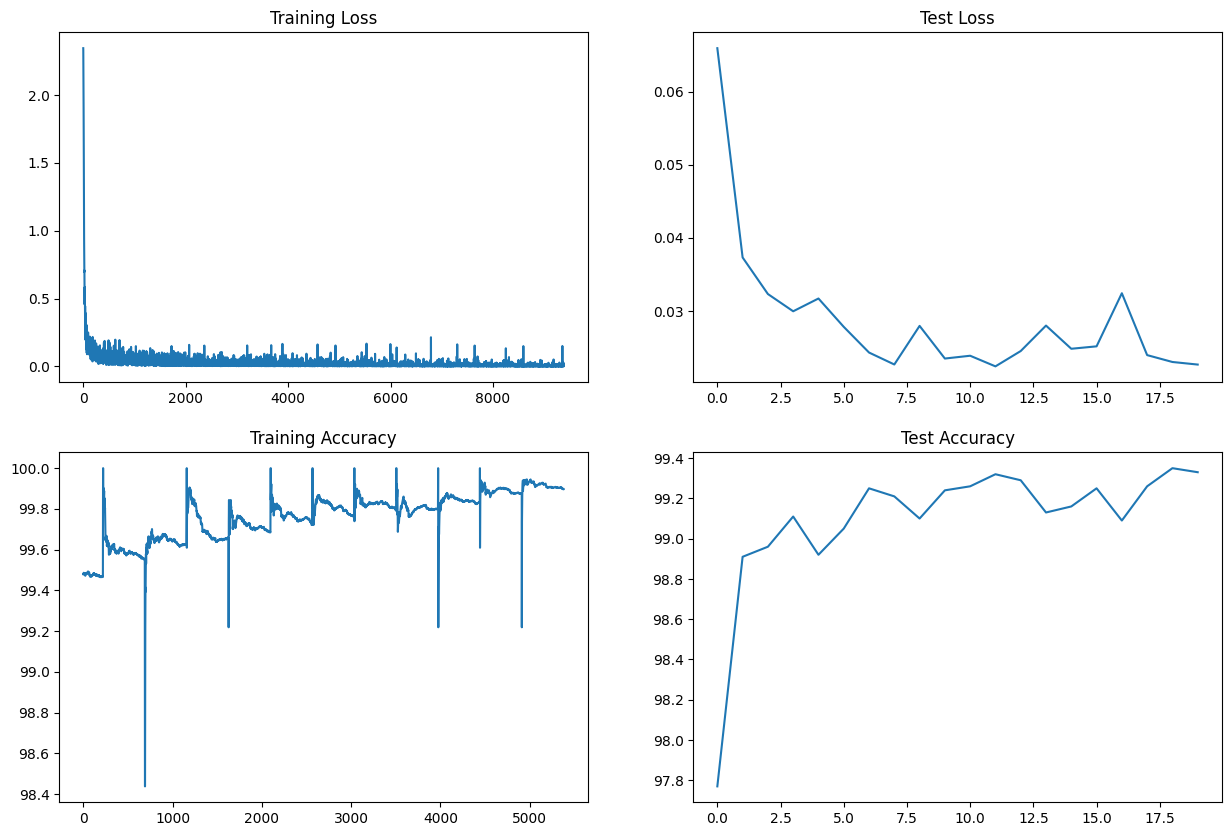

In [11]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")